# Проект "Автоматизация коммуникаций"
##Задача
Ежедневно Wildberries получает огромное количество различных обращений клиентов по различным вопросам и из разных источников. Многие из этих обращений обрабатываются при помощи автоматизированных систем. Вам предстоит создать вопросно-ответную систему, которая генерирует ответ на обращения в техподдержку для менеджеров ПВЗ.

Вам будут доступны данные в виде истории вопросов и ответов на них, а также база знаний в виде документов, в которых содержится информация, регламентирующая работу менеджера на ПВЗ и описывающая многие бизнес-
процессы.

## 2. Проработка вариантов решения
На данном этапе вам необходимо:
- Проанализировать имеющиеся решения
- Обозначить основные плюсы и минусы каждого из потенциальных решений
- Выбрать подходящее решение (алгоритм или набор алгоритмов) для данной задачи и обосновать его
- Сформировать обучающую выборку
- Спроектировать схему валидации с учетом специфики задачи


Сокращения:\
**АС** - Автоматизированная система

### **Recap предыдущего этапа**
---

#### **Формализация задачи**

**Цель:** автоматизивовать систему поддержки пользователей для менеджеров ПВЗ. \
**Задача:** разработать АС техподдержки для взаимодействия с пользователями в формате диалога. \

**Входные данные:** строка (ответ/вопрос/запрос) \
**Выходные данные:** строка (суммаризированный ответ, генерация ответа/вопроса) \

#### **Архитектура системы**

**Архитектура системы:** RAG-система; \
**Этапы функционирования системы:**
  *   Обработка входных данных
  *   Поиск информации в базе данных
  *   Формирование промпта

#### **Анализ данных**

1. **Датасет "Вопрос-Ответ"** \
  * Статистика длин текстов:
    1. Длины текстов (медианнные значения):
      - Вопрос: 36 символ
      - Ответ: 151 символ
    2. Макс. и мин. зафиксированные длины текстов:
      - Вопрос: 2 и 652 символ
      - Ответ: 9 и 1642 символ
    3. С.к.о. длин текстов:
      - Вопрос: 31
      - Ответ: 181.9
  * Кластеризация:
    - Вопросы сложно разделить на осмысленные кластеры;
    - Ответы можно объединить в кластеры по общей теме;
  * Именованные сущности:
    - В запросе пользователя не всегда есть сущности;
    - В потенциальном ответе много сущностей.

2. **Датасет "База знаний"**
  * Статистика длин текстов:
    1. Длины чанков (медианнные значения): 434 символ
    2. Макс. и мин. зафиксированные длины чанков: 15 и 3369 символ
    3. С.к.о. длин чанков: 451.1
  * Кластеризация: данные базы знаний трудно разделить на осмысленные кластеры.
  * Именованные сущности: отмечается наличие множества именованных сущностей в чанках.

**На что можно было еще посмотреть:**
- Тематическое моделирование для базы знаний
- document_id, part_id, проверить расположение точек относительно их document_id
- кластеризация текстов вопрос-ответ, визуализация (определение в кластер по ближайшему + NER)
- визуализация вопросов и ответов в одном пространстве
- LLM API
- LLM-clustering


### **Обзор и анализ решений**
---

#### **Ориентиры и критерии для системы**

Вспомним \
**Цель:** автоматизивовать систему поддержки пользователей для менеджеров ПВЗ. \
**Задача:** разработать АС техподдержки для взаимодействия с пользователями в формате диалога. \

**Входные данные:** строка (ответ/вопрос/запрос) \
**Выходные данные:** строка (суммаризированный ответ, генерация ответа/вопроса) \

Для тривиальной RAG-системы можно выдвинуть следующие критерии (пример требований заказчика):
1. Скорость ответа (быстродействие)
2. Качество ответа (адекватность)
3. Релевантность ответа (отвечает на вопрос пользователя)

Здесь опущены требования к масштабированию, распараллеливанию процессов обработки запросов и тп, поскольку это не первоочередная задача.

##### Ориентиры

**Ориентиры** - это те аспекты, на которые будет обращать внимание разработчик, зная подробности разработки, опираясь на требования заказчика.\
Поиск решения осуществляется из следующих соображений:
- Объем и свойства данных \
данные, описывающие предметную область;
- Быстродействие системы \
насколько быстро реагирует система на запрос пользователя;
- Качество ответа \
связность слов и логика ответа модели, адекватность;
- Релевантность ответа \
ответ ожидаем пользователем и отвечает на его вопрос;
- Объем занимаемой ОЗУ \
как система зависима от ОЗУ во время своей работы
- Ограничения применимости алгоритмов \
алгоритм может быть применим в задаче без потери своих характеристик

###### Подробнее про ориентиры

Ориентиры определяют решения, а именно, используемые структуры данных и алгоритмы.
1. **Объем и свойства данных :** \
  объем и наличие определенных свойств и закономерностей в данных позволит выбрать семейство алгоритмов или связку алгоритмов.

2. **Скорость ответа:** \
  зависит от
  - Процесса обработка входных данных;
  - Организации и поиска данных в БД;
  - Формирования промпта и генерации ответа.

3. **Качество ответа:** \
  зависит от
  - Свойств обучающих данных;
  - Способа обработки и представления входных данных;
  - Метода поиска данных в БД;
  - Качества подсказок в промпте;
  - Модели LLM.

4. **Релевантность ответа:** \
  зависит от
  - Полноты обучающих данных;
  - Способа обработки и представления входных данных
  - Метода поиска данных в БД;
  - Модели LLM.

5. **Ограничения применимости алгоритмов** \
  зависят от объема и свойств обучающих данных

##### Требования

После того, как были получены критерии от заказчика и разработчик определил ориентиры, можно определить требования (желания, ожидания) при разработке системы согласно всем этапам её функционирования.
1. **Обучающие данные:**
  - полные (охватывают всю предметную область);
  - есть закономерности и паттерны;
2. **Предобработка и способ представления данных:**
  - проводится без искажения данных;
  - сохранение информации или сжатие без потери качества работы системы;
  - быстрая предобработка;
  - нет утечки памяти ОЗУ;
3. **Организация данных в БД**
  - оптимизированная организация данных для поиска;
  - нет излишней информации;
4. **Поиск данных в БД:**
  - поиск наиболее релевантных данных;
  - поиск с использованием всей информацией входного запроса;
  - быстрый поиск данных;
  - нет утечки памяти ОЗУ;
5. **Генерация ответа:**
  - легкая модель;
  - модель не забывает контекст;
  - качественная подсказка в промпте;
  - адекватность ответа;
  - релевантность ответа;
  - быстрая генерация.

#### **Поиск решения**

И так, цель, задача и требования определены. Приступим к поиску решений.


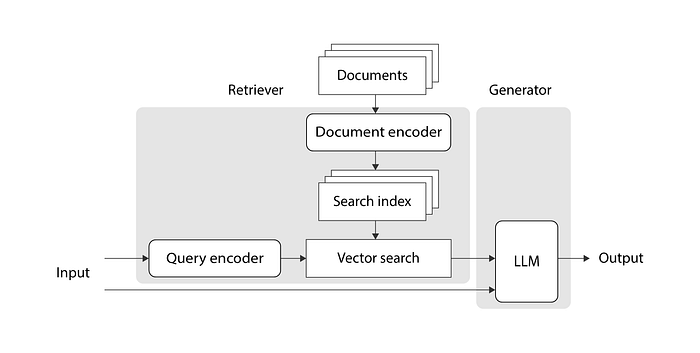

Статья: https://habr.com/ru/companies/wunderfund/articles/779748/

##### Подходы работы с данными

В постановке задачи указано, что входные данные - строковый тип. Отсюда возникают три подхода к рассмотрению задачи с точки зрения подбора релевантных чанков в БД:

- **Текстовый поиск**\
  Предположение:
  >  Выполнять поиск по ключевым словам. Если есть ключевое слово в запросе, то скорее всего оно должно быть в чанке.
  
  Преимущества:
  > Полезен, когда ищут идентификаторы пользователей, коды продуктов, адреса и любые другие данные.

  Недостатки:
  > Предположение выполняется не всегда. Также словарь ключевых слов или индекс может стать огромным, в ином случае поиск чувствителен к словам OOV.

- **Векторный поиск**\
  Предположение:
  > Выполнять поиск на основе векторных представлений (эмбеддингов).
  
  Преимущества:
  > Возможно нахождение соответствия поисковому запросу в документах, в которых нет ключевых слов из запроса, но общий смысл которых близок к смыслу запроса.

  Недостатки:
  > Фиксированный размер эмбеддингов. Упаковка большой/малой информации в вектор не во всех случая удачная. Также для LLM свойственно забывать информацию для больших текстов.

- **Гибридный поиск**\
  Предположение:
  > Использовать текстовый и векторный подходы совместно.
  
  Преимущества:
  > Более точный подбор чанков из БД на основе совмещения двух подходов, избавление от недостатков одиночных подходов.

  Недостатки:
  > Необходимо определиться с методом объединения ответов одиночных подходов. Хранение моделей двух подходов.

**Вывод:**\
Таким образом, для более точной и качественной системы RAG будет правильным решеним использование **гибридного подхода** для работы с текстовыми данными запроса и данными в БД. Таким подходом будет обеспечено требование адекватности и релевантности ответа.



##### Алгоритмы и архитектуры

###### Алгоритмы для текстового поиска

Тематическое моделирование:
1. Latent Semantic Analysis (LSA):\
  Преимущества:
  > - Простота и понятность алгоритма
  - Эффективность на небольших наборах данных
  - Хорошо работает с частотными матрицами

  Недостатки:
  > - Не учитывает вероятностный характер тематического моделирования
  - Не учитывает многомерность тем в документе
  - Требует больших объемов памяти при работе с большими корпусами текстов

2. Probabilistic Latent Semantic Analysis (pLSA):\
  Преимущества:
  > - Учитывает вероятностный характер тематического моделирования
  - Может работать с разреженными данными
  - Хорошо подходит для построения мультимодальных моделей

  Недостатки:
  > - Задача стохастического матричного разложения некорректно поставлена
  - При добавлении нового документа d в коллекцию распределение p (t | d) невозможно вычислить по тем же формулам, что и для остальных документов, не перестраивая всю модель заново.
  - Число параметров растёт линейно по числу документов в коллекции, что может приводить к переобучению.

3. Latent Dirichlet Allocation (LDA):\
  Преимущества:
  > - Учитывает многомерность тем в документе
  - Позволяет моделировать различные вероятностные распределения
  - Хорошо работает с большими наборами текстов

  Недостатки:
  > - Не вполне понятно, чем обосновано использование распределения Дирихле с лингвистической точки зрения
  - Сглаживание вместо разреживания
  - На больших данных нет отличий от pLSA

4. Additive Regularization of Topic Models (ARTM):\
  Преимущества:
  > - Позволяет включать дополнительные регуляризаторы для улучшения качества модели
  - Гибкость в настройке параметров модели
  - Хорошо работает с разреженными данными

  Недостатки:
  > - Требует опыта и экспертизы для эффективной настройки регуляризаторов
  - Может потребовать больше времени на обучение и оптимизацию модели
  - Иногда может быть сложно интерпретировать результаты

**Вывод:**\
Тематическое моделирование может помочь организовать чанки в базе знаний по темам, тем самым будет ускорен процесс поиска более релевантных чанков. Таким образом будут обеспечены требования быстродействия системы, адекватности и релевантности ответа.\
На этапе анализа данных не было проведено тематическое моделирование данных базы знаний, однако на защите были представлены результаты других участников. По ним можно сделать вывод, для тематического моделирования следует использовать более сложные подходы. Одним из таким подходов может быть сочетание перечисленных алгоритмов с LLM. В таком случае, лучшим выбором будет сочетание BigARTM + LLM, поскольку BigARTM разрабатывался с целью побить качество ранее разработанных алгоритмов, или ознакомиться с [моделями](https://paperswithcode.com/task/topic-models).

Выделение сущностей:
1. Правила и шаблоны:\
  Преимущества:
  > - Простота в реализации
  - Хорошо работают для выделения именованных сущностей с явными шаблонами

  Недостатки:
  > - Требуют ручного создания правил и шаблонов
  - Могут быть неэффективными для сложных или изменчивых структур текста

2. Conditional Random Fields (CRF):\
  Преимущества:
  > - Учитывают контекстные зависимости между сущностями
  - Могут улучшить точность выделения сущностей

  Недостатки:
  > - Требуют большого объема размеченных данных для обучения
  - Сложны в настройке и требуют оптимизации гиперпараметров

3. SVM:\
  Преимущества:
  > - Хорошо работают на небольших наборах данных
  - Могут обрабатывать большое количество признаков

  Недостатки:
  > - Не учитывают контекстные зависимости между словами
  - Могут быть менее эффективными для сложных структур текста

4. RNN и LSTM:\
  Преимущества:
  > - Могут улавливать долгосрочные зависимости в тексте
  - Хорошо работают на последовательных данных

  Недостатки:
  > - Могут столкнуться с проблемой затухания градиентов
  - Требуют большого объема вычислений и ресурсов

5. Transformers или GPT:\
  Преимущества:
  > - Могут обрабатывать большие объемы текста
  - Способны улавливать сложные зависимости между словами

  Недостатки:
  > - Требуют большого объема данных для обучения
  - Могут быть вычислительно затратными

**Вывод:**\
Выделение именованных сущностей позволит обеспечить требование  быстродействия системы, адекватности и релевантности ответа. Анализ данных показал, что именованных сущностей больше в потенциальном ответе (см. датасет "Вопрос-ответ)". Этим фактом можно воспользоваться для более точного подбора чанков из БД.\
На сегодняшний момент многие библиотеки реализуют алгоритмы задачи NER на базе трансформерных архитектур, поскольку они показывают лучшие метрики качества. Таким образом, предпочтение в модели для задачи NER будет отдано трансформерам. В качестве таких могут быть выбраны реализации из открытых библиотек или [здесь](https://paperswithcode.com/task/named-entity-recognition-ner).

###### Алгоритмы для векторного поиска

Векторизация текстов:
1. TF-IDF, BM25:\
  Преимущества:
  > - Простота и понятность
  - Хорошо работают на коротких текстах
  - TF-IDF учитывает важность слова в документе

  Недостатки:
  > - Не учитывают семантическую связь между словами
  - Требуют предварительной обработки текста

2. Word2Vec (Skip-gram, CBOW), Doc2Vec:\
  Преимущества:
  > - Учитывают семантическую связь между словами
  - Могут работать с необработанными данными

  Недостатки:
  > - Требуют большого объема данных для обучения
  - Могут иметь проблемы с редкими словами

3. FastText:\
  Преимущества:
  > - Учитывает внутреннюю структуру слов
  - Хорошо работает с редкими словами

  Недостатки:
  > - Требует больших объемов данных для обучения
  - Может быть медленным на больших корпусах текста

4. CNN:\
  Преимущества:
  > - Хорошо работает на последовательных данных
  - Может улавливать локальные паттерны

  Недостатки:
  > - Требует большого объема данных для обучения
  - Может быть сложным для интерпретации

5. RNN (LSTM, GRU, ELMO):\
  Преимущества:
  > - Учитывает контекст и последовательность слов
  - Может работать с разной длиной входных данных

  Недостатки:
  > - Может иметь проблемы с долгосрочными зависимостями
  - Требует больших вычислительных ресурсов

6. Transformers (Bert, E5, LaBSE):\
  Преимущества:
  > - Состоятельные результаты на различных задачах NLP
  - Учитывают контекст и семантические связи между словами

  Недостатки:
  > - Требуют больших объемов данных для обучения
  - Могут быть вычислительно затратными


**Вывод:**\
Векторные представления текстов позволяют разделить входные данные по кластерам, что также улучшит работу RAG-системы. Проведенный анализ данных показал, что в случае датасета "Вопрос-ответ" сложно провести разделение вопросов на смысловые кластеры, однако ответы можно объединить в кластеры по общей тематике. Для датасета "База знаний" обнаружено, что данные базы знаний также сложно разделить на смысловые кластеры.\
В то же время GPT модель от OpenAI справляется с данной задачей. Следовательно, для решения задачи кластеризации использовались слабые модели.\
В [статье](https://habr.com/ru/companies/wunderfund/articles/779748/) упоминаются ChatGPT, LangChan и Semantic Kernel для разработки RAG-системы. Однако, можно попробовать их использовать на этапе кластеризации вопросов и ответов. Также можно попробовать воспользоваться [ClusterLLM](https://github.com/zhang-yu-wei/ClusterLLM). Возможны трудности с русскоязычными текстами, тогда в [статье](https://habr.com/ru/articles/769124/) предлагают
saiga_mistral_7b_lora и Mistral-7B-OpenOrca (нужна лиценция)


Выше описано применение векторных представления для входного запроса и датасета "Вопрос-ответ". Однако, их можно применить и для базы знаний. В [статье](https://habr.com/ru/companies/wunderfund/articles/779748/) упоминается, что  поисковые сервисы обычно используют некую разновидность алгоритма ANN (Approximate Nearest Neighbor, приближённый поиск ближайшего соседа)(например, HNSW - Hierarchical Navigable Small World, иерархический маленький мир). Поиск обычно выполняется с применением некоего поискового сервиса — наподобие [FAISS](https://github.com/facebookresearch/faiss) или [Azure Cognitive Search](https://azure.microsoft.com/en-us/products/ai-services/ai-search/). Такие сервисы поддерживают различные способы поиска документов, которые хорошо сочетаются с RAG.


##### Архитектура RAG-системы

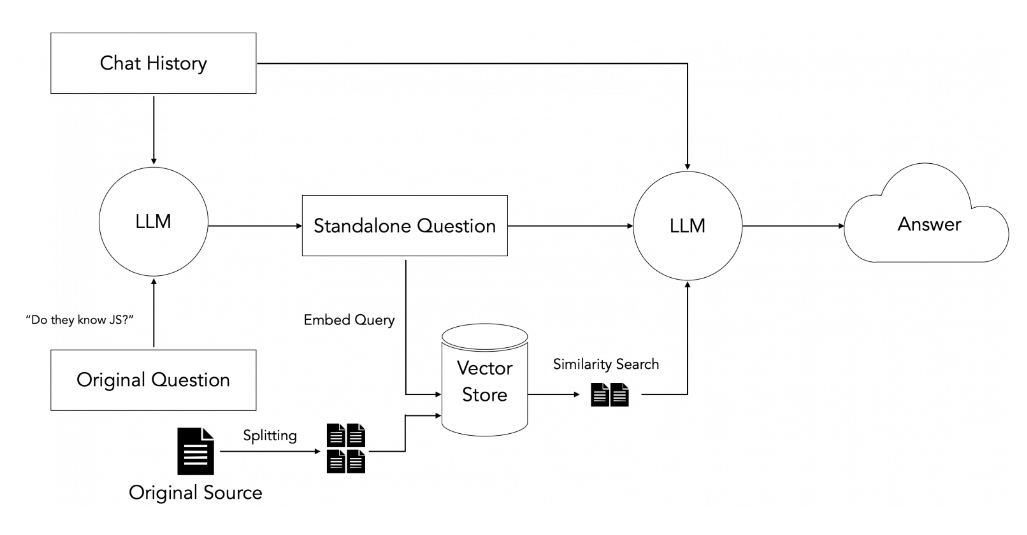

[Cтатья](https://habr.com/ru/companies/wunderfund/articles/779748/)

#### **Метрики оценки**
---

Для каждого алгоритма есть свои метрики оценки:
- Метрики оценки кластеризации
- Метрики оценки выявления именованных сущностей (необходима разметка)
- Метрики оценки тематического моделирования

Здесь они не будут перечисляться. БОльший акцент сделан на метрики оценки работы ретривера, LLM и всей RAG-системы.

##### Метрики оценки ответов

Работа: https://towardsdatascience.com/top-evaluation-metrics-for-rag-failures-acb27d2a5485

Проблемы с оценкой правильности ответов LLM:
*   Галлюцинации
*   Разнообразие ответов
*   Оценка фактичности:
  - Использование вероятностей токенов (Например: метрика BARTScore);
  - Использование дополнительных классификаторов (требует доступа к скрытым состояниям модели);
  - Множественные ответы


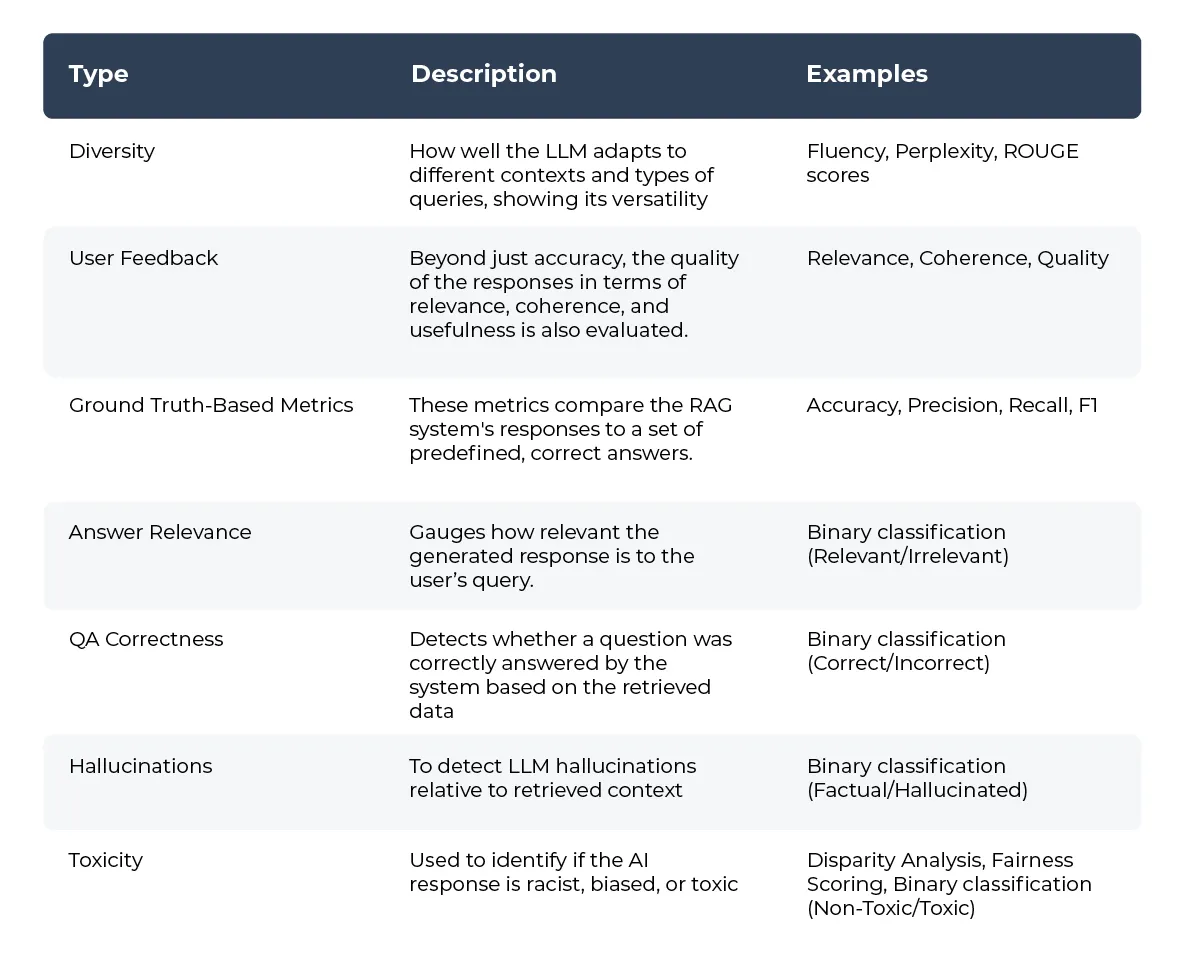

##### Метрики оценки работы ретривера

Работа: https://towardsdatascience.com/top-evaluation-metrics-for-rag-failures-acb27d2a5485

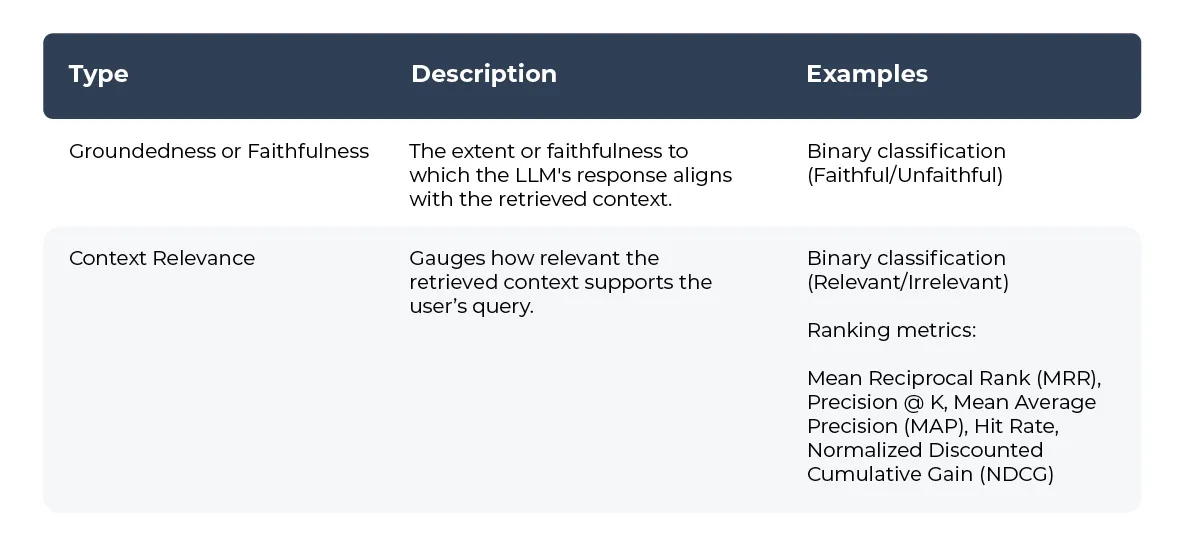

##### Framework RAGAS

В [статье](https://habr.com/ru/articles/778166/) идет речь об оценке пайплайнов RAG-систем. Упоминаются те же метрики, что были на изображениях выше, однако автор статьи делиться ссылкой на [фреймворк RAGAS](https://github.com/explodinggradients/ragas) (Retrieval Augmented Generation Automated Scoring), который позволяет удобно и быстро замерить качесто RAG-системы.

Метрики оценки в RAGAS:
- **Faithfulness** \
Оценивает, насколько ответы языковой модели точно отражают информацию, содержащуюся в источниках данных.

- **Answer Relevancy** \
Показывает, насколько ответы соответствуют заданным вопросам.

- **Context Recall** \
Оценивает, сколько информации из контекста использовано в ответе.

- **Context Precision** \
Оценивает, насколько точно и релевантно контекстная информация использована.

- **Answer Semantic Similarity** \
Измеряет, насколько семантически близок ответ модели к эталонному ответу.

- **Answer Correctness** \
Проверка на то, предоставляет ли модель точную и достоверную информацию в ответе.

Для оценки конвейера RAG RAGA ожидает следующую информацию:
- `question`: пользовательский запрос, который является входными данными конвейера RAG. Вход.
- `answer`: сгенерированный ответ из конвейера RAG. Выход.
- `contexts`: Контексты, полученные из внешнего источника знаний, используемые для ответа на вопрос `question`.
- `ground_truths`: Основной ответ на вопрос `question`. Это единственная информация, аннотированная человеком. Эта информация требуется только для метрики `context_recall`.


**Вывод:**\
Для валидации RAG-пайплайна при помощи RAGAS нужно будет подготовить пары `question`-`ground_truths`, в нашем распоряжении для этих целей есть датасет "Вопрос-ответ".

## ИТОГ

В результате обзора и анализа решений был выбран набор алгоритмов для разработки RAG-системы. Основная идея - использовать более сложные модели, чтобы более точно выявлять структуры и паттерны в данных. Примерная структура RAG-системы была изображена в разделе "Архитектура RAG-cистемы".

Алгоритмы и инструкции для каждого этапа:
1. Формирование обучающих данных и обучение моделей:\
  Предлагается использовать предобученные модели\
  Предложения по улучшению в [статье](https://habr.com/ru/articles/791966/) (файнтюниг моделей)
2. Обработка запроса:
  - Очистка текста (открытые библиотеки);
  - Проверить модели ChatGPT, LangChan, Semantic Kernel, ClusterLLM, saiga_mistral_7b_lora, Mistral-7B-OpenOrca на данных "Вопрос-ответ"
  - Оценить качество формируемых эмбеддингов на задаче кластеризации, сформировать векторные представления;
3. Поиск эталонного ответа в данных "Вопрос-ответ":
  - Использовать ANN-алгоритм ([Faiss](https://github.com/facebookresearch/faiss), [Azure Cognitive Search](https://azure.microsoft.com/en-us/products/ai-services/ai-search/)) для поиска схожего вопроса и соответствующего ответа для него;
  - Пропустить эталонный ответ через трансформерный алгоритм для задачи NER (открытые библиотеки,  [benchmark](https://paperswithcode.com/task/named-entity-recognition-ner));
4. Поиск документов в базе знаний:
  - Проверить гипотезу о тематическом моделировании с помощью BigARTM + LLM;
  - Пропустить документы через трансформер для задачи NER (открытые библиотеки,  [benchmark](https://paperswithcode.com/task/named-entity-recognition-ner));
  - Оценить качество работы алгоритмов для задачи  тематического моделирования;
  - Проверить ANN-алгоритм для поиска документов в базе знаний  ([Faiss](https://github.com/facebookresearch/faiss), [Azure Cognitive Search](https://azure.microsoft.com/en-us/products/ai-services/ai-search/))(одиночный способ или гибридный с NER или ТМ).
5. Генерация ответа:
  - Проверить модели ChatGPT, LangChan, Semantic Kernel, saiga_mistral_7b_lora, Mistral-7B-OpenOrca;
6. Валидация пайплайна RAG-системы:
  - Фреймворк [RAGAS](https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a)
  - Применение данных "Вопрос-ответ" для валидации


**Замечание:** \
Предложены возможные алгоритмы для каждого этапа, однако, для baseline будет реализована более простая система. Усложнения на шаге оптимизации.